<a href="https://colab.research.google.com/github/FREDY129053/Practise_Temp/blob/main/Practise_Veg_Fru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Подгрузка данных из датасета**

---



In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q kaggle  # Установка зависимости для скачки датасета

In [ ]:
from google.colab import files

files.upload()  # Загрузка файла с данными от Kaggle API

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fredy129053","key":"732172104435df3745774c6e74467316"}'}

In [ ]:
!mkdir ~/.kaggle  # Создание папки для данных Kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/  # Перенос файла в папку

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json  # Задаем права на файл

In [ ]:
!kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition  # Скачиваем датасет

100% 1.98G/1.98G [00:28<00:00, 97.9MB/s]
100% 1.98G/1.98G [00:28<00:00, 75.7MB/s]


In [ ]:
!unzip fruit-and-vegetable-image-recognition.zip  # Распаковываем датасет

In [ ]:
!mkdir /content/drive/MyDrive/Fruits_and_Vegetables_Datset

In [ ]:
!cp -r /content/test /content/drive/MyDrive/Fruits_and_Vegetables_Datset/test

In [ ]:
!cp -r /content/train /content/drive/MyDrive/Fruits_and_Vegetables_Datset/train

In [ ]:
!cp -r /content/validation /content/drive/MyDrive/Fruits_and_Vegetables_Datset/validation

## Аугментация картинок

In [ ]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Путь к папке с изображениями
folder_path = "/content/drive/MyDrive/Fruits_and_Vegetables_Datset/train"

# Количество аугментаций на каждую картинку
num_augmentations = 2

# Параметры аугментации
datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.4,
    horizontal_flip=True,
    brightness_range=[0.2, 1.5],
    fill_mode='nearest'
)

# Получаем список всех подпапок
subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]

# Для каждой подпапки
for subfolder in subfolders:
    # Получаем список всех файлов изображений
    image_files = [f.path for f in os.scandir(subfolder) if f.is_file() and f.name.endswith(('.png', '.jpg', '.jpeg'))]

    # Для каждого изображения
    for image_file in image_files:
        # Загружаем изображение и преобразуем его в массив
        img = load_img(image_file)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)

        # Генерируем и сохраняем аугментации
        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=subfolder, save_prefix='MY_', save_format='jpeg'):
            i += 1
            if i >= num_augmentations:
                break

## Тест модели VGG19

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

w, h = 224, 224

training_set = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Fruits_and_Vegetables_Datset/train',
    labels='inferred',  # Формирование уровней на основе структуры датасета (яблоко, бананы и тд)
    label_mode='categorical',  # Режим уровней и создание (в данном случае) векторной формы уровней
    class_names=None,  # Список классов (папки итак отсортированы, можно не ставить)
    color_mode='rgb',  # Режим картинок
    batch_size=32,
    image_size=(w, h),
    shuffle=True,
    seed=42,  # Смысл жизни
    validation_split=None,
    subset=None,
    interpolation='bilinear',  # Нужно для алгоритма сжатия картинок
    follow_links=False,  # Переход по символьным ссылкам папок нахер
    crop_to_aspect_ratio=False  # обрезать тоже не надо
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Fruits_and_Vegetables_Datset/validation',
    labels='inferred',  # Формирование уровней на основе структуры датасета (яблоко, бананы и тд)
    label_mode='categorical',  # Режим уровней и создание (в данном случае) векторной формы уровней
    class_names=None,  # Список классов (папки итак отсортированы, можно не ставить)
    color_mode='rgb',  # Режим картинок
    batch_size=32,
    image_size=(w, h),
    shuffle=True,
    seed=42,  # Смысл жизни
    validation_split=None,
    subset=None,
    interpolation='bilinear',  # Нужно для алгоритма сжатия картинок
    follow_links=False,  # Переход по символьным ссылкам папок нахер
    crop_to_aspect_ratio=False  # обрезать тоже не надо
)

conv_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))

x = tf.keras.layers.Flatten()(conv_model.output)

x = tf.keras.layers.Dense(100, activation='relu')(x)
x = tf.keras.layers.Dense(100, activation='relu')(x)
x = tf.keras.layers.Dense(100, activation='relu')(x)

predictions = tf.keras.layers.Dense(36, activation='softmax')(x)

full_model = tf.keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()


Found 3115 files belonging to 36 classes.
Found 351 files belonging to 36 classes.
80134624/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112,

In [3]:
for layer in conv_model.layers:
    layer.trainable = False

In [4]:
full_model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
                  metrics=['accuracy'])

history = full_model.fit(
    training_set,
    validation_data = validation_set,
    workers=10,
    epochs=7,
)

Epoch 1/7
98/98 [==============================] - 3013s 30s/step - loss: 0.3317 - accuracy: 0.1175 - val_loss: 0.1031 - val_accuracy: 0.4188
Epoch 2/7
98/98 [==============================] - 3064s 31s/step - loss: 0.1033 - accuracy: 0.4083 - val_loss: 0.0567 - val_accuracy: 0.7379
Epoch 3/7
98/98 [==============================] - 2930s 30s/step - loss: 0.0640 - accuracy: 0.6533 - val_loss: 0.0388 - val_accuracy: 0.8490
Epoch 4/7
98/98 [==============================] - 2895s 29s/step - loss: 0.0444 - accuracy: 0.8128 - val_loss: 0.0292 - val_accuracy: 0.9145
Epoch 5/7
98/98 [==============================] - 2892s 29s/step - loss: 0.0327 - accuracy: 0.8992 - val_loss: 0.0226 - val_accuracy: 0.9459
Epoch 6/7
98/98 [==============================] - 2913s 30s/step - loss: 0.0244 - accuracy: 0.9358 - val_loss: 0.0186 - val_accuracy: 0.9459
Epoch 7/7
98/98 [==============================] - 2867s 29s/step - loss: 0.0185 - accuracy: 0.9579 - val_loss: 0.0162 - val_accuracy: 0.9516


In [5]:
full_model.save_weights('/content/drive/MyDrive/MODEL_VGG19.h5')

In [7]:
full_model.save('/content/drive/MyDrive/MODEL_VGG19_WWWW.keras')

In [8]:
full_model.save('/content/drive/MyDrive/MODEL_VGG19_W.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
import json

with open('/content/drive/MyDrive/train_history_VGG19', 'w') as f:
  json.dump(history.history, f)

##**Создание модели**

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt



In [ ]:
w, h = 128, 128

training_set = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Fruits_and_Vegetables_Datset/train',
    labels='inferred',  # Формирование уровней на основе структуры датасета (яблоко, бананы и тд)
    label_mode='categorical',  # Режим уровней и создание (в данном случае) векторной формы уровней
    class_names=None,  # Список классов (папки итак отсортированы, можно не ставить)
    color_mode='rgb',  # Режим картинок
    batch_size=32,
    image_size=(w, h),
    shuffle=True,
    seed=42,  # Смысл жизни
    validation_split=None,
    subset=None,
    interpolation='bilinear',  # Нужно для алгоритма сжатия картинок
    follow_links=False,  # Переход по символьным ссылкам папок нахер
    crop_to_aspect_ratio=False  # обрезать тоже не надо
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Fruits_and_Vegetables_Datset/validation',
    labels='inferred',  # Формирование уровней на основе структуры датасета (яблоко, бананы и тд)
    label_mode='categorical',  # Режим уровней и создание (в данном случае) векторной формы уровней
    class_names=None,  # Список классов (папки итак отсортированы, можно не ставить)
    color_mode='rgb',  # Режим картинок
    batch_size=32,
    image_size=(w, h),
    shuffle=True,
    seed=42,  # Смысл жизни
    validation_split=None,
    subset=None,
    interpolation='bilinear',  # Нужно для алгоритма сжатия картинок
    follow_links=False,  # Переход по символьным ссылкам папок нахер
    crop_to_aspect_ratio=False  # обрезать тоже не надо
)

Found 3152 files belonging to 36 classes.
Found 351 files belonging to 36 classes.


##Создание модели

In [ ]:
seq_model = tf.keras.models.Sequential()

###Создание слоев

In [ ]:
seq_model.add(tf.keras.layers.Conv2D(
    filters=32,  # Опционально
    kernel_size=3,
    padding='same',
    activation='relu',
    input_shape=[w, h, 3],
))

seq_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))

seq_model.add(tf.keras.layers.MaxPool2D(
    pool_size=2,
    strides=2
))

In [ ]:
seq_model.add(tf.keras.layers.Dropout(0.25))

In [ ]:
seq_model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=3,
    padding='same',
    activation='relu',
))

seq_model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=3,
    activation='relu',
))

seq_model.add(tf.keras.layers.MaxPool2D(
    pool_size=2,
    strides=2
))

In [ ]:
seq_model.add(tf.keras.layers.Dropout(0.25))

In [ ]:
seq_model.add(tf.keras.layers.Flatten())

In [ ]:
seq_model.add(tf.keras.layers.Dense(
    units=256,  # Опционально
    activation='relu'
))

seq_model.add(tf.keras.layers.Dense(
    units=128,  # Опционально
    activation='relu'
))

In [ ]:
seq_model.add(tf.keras.layers.Dropout(0.5))  # Чтобы избежать переобучения

In [ ]:
seq_model.add(tf.keras.layers.Dense(units=36, activation='softmax'))  # Выходной слой. 36 потому что у нас 36 классов!!!

###Обучение модели

In [ ]:
# my_optimizer = 'adam'
my_optimizer = tf.keras.optimizers.Adadelta()

seq_model.compile(optimizer=my_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
seq_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        36928     
                                                      

In [ ]:
train_history = seq_model.fit(x=training_set, validation_data=validation_set, epochs=35)

Epoch 1/35
99/99 [==============================] - 525s 5s/step - loss: 34.6497 - accuracy: 0.0270 - val_loss: 6.6567 - val_accuracy: 0.0199
Epoch 2/35
99/99 [==============================] - 368s 4s/step - loss: 18.5195 - accuracy: 0.0286 - val_loss: 5.5751 - val_accuracy: 0.0171
Epoch 3/35
99/99 [==============================] - 346s 3s/step - loss: 14.3419 - accuracy: 0.0320 - val_loss: 4.9643 - val_accuracy: 0.0199


KeyboardInterrupt: 

In [ ]:
seq_model.save('trained_model_updated.h5')

In [ ]:
import json

with open('train_history', 'w') as f:
  json.dump(train_history.history, f)

In [ ]:
print(f"Точность модели = {train_history.history['val_accuracy'][-1] * 100:.2f}%")

Точность модели = 95.16%


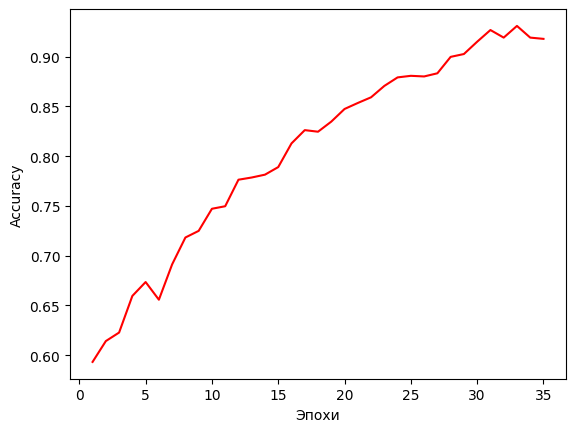

In [ ]:
epochs = [i for i in range(1, 36)]

plt.plot(epochs, train_history.history['accuracy'], color='r')
plt.xlabel('Эпохи')
plt.ylabel('Accuracy')
plt.show();

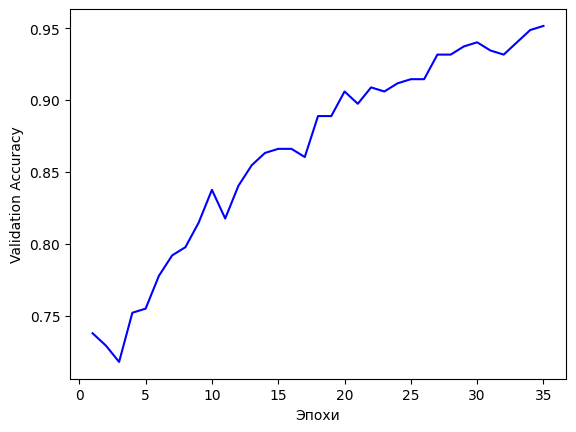

In [ ]:
plt.plot(epochs, train_history.history['val_accuracy'], color='b')
plt.xlabel('Эпохи')
plt.ylabel('Validation Accuracy')
plt.show();

##Загрузка модели и тест ее

In [ ]:
model = tf.keras.models.load_model('/content/trained_model_updated.h5')

In [ ]:
image_path = '/content/i.webp'
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(64, 64))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # В двумерную матрицу

prediction = model.predict(input_arr)
print(prediction[0])

1/1 [==============================] - 0s 49ms/step
[7.03286378e-06 2.43377275e-04 4.55246573e-06 2.10757687e-04
 2.82172238e-07 3.90843452e-05 6.60500769e-03 1.21239223e-08
 4.71699906e-07 9.86566651e-04 2.99125986e-08 9.11170972e-10
 6.66140849e-08 8.86245004e-07 5.62566072e-07 5.09376650e-06
 8.28787279e-07 1.26622955e-03 1.72777004e-09 2.53893148e-07
 1.08986974e-07 4.86476565e-05 9.14013526e-06 5.23818744e-06
 3.09170896e-12 3.28422822e-02 6.32756855e-04 2.79723966e-10
 1.10029141e-05 2.66433819e-10 7.70489852e-11 9.57071364e-01
 9.99017709e-12 7.23175935e-06 7.34142304e-07 3.08251657e-07]


In [ ]:
result_index_of_prediction = np.where(prediction[0] == max(prediction[0]))

test_set = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Fruits_and_Vegetables_Datset/test',
    labels='inferred',  # Формирование уровней на основе структуры датасета (яблоко, бананы и тд)
    label_mode='categorical',  # Режим уровней и создание (в данном случае) векторной формы уровней
    class_names=None,  # Список классов (папки итак отсортированы, можно не ставить)
    color_mode='rgb',  # Режим картинок
    batch_size=32,
    image_size=(64, 64),
    shuffle=True,
    seed=42,  # Смысл жизни
    validation_split=None,
    subset=None,
    interpolation='bilinear',  # Нужно для алгоритма сжатия картинок
    follow_links=False,  # Переход по символьным ссылкам папок нахер
    crop_to_aspect_ratio=False  # обрезать тоже не надо
)

print(f"Result of prediction: \nOn image is {test_set.class_names[result_index_of_prediction[0][0]]}")

Found 359 files belonging to 36 classes.
Result of prediction: 
On image is sweetcorn
